## Klasy bazowe

In [14]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="VJWPM6Pny9FfSs77ewVfHOHgr",
                        project_name="deep-learning", workspace="edzia")

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/edzia/deep-learning/428e9a1222264dd0884b223e094c8b77
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [2]          : (0.329, 0.329)
COMET INFO:     epoch accuracy [10]   : (0.15744000673294067, 0.3289400041103363)
COMET INFO:     epoch loss [10]       : (1.8974875211715698, 2.1948533058166504)
COMET INFO:     epoch time [10]       : (8.339861, 32.396727)
COMET INFO:     f1 [2]                : (0.329, 0.329)
COMET INFO:     loss [2]              : (1.8974875211715698, 1.8974875211715698)
COMET INFO:     sys.gpu.0.total_memory: (2101739520.0, 2101739520.0)
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/edzia/deep-learning/c2fc6b41644b49a39f09b11feb266b4e



In [15]:
import abc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import datetime
import pandas as pd
import random


In [16]:
class AbstractLayer(tf.keras.layers.Layer):
    """Abstract Layer."""
    
    def __init__(self):
        """Inits the class."""
        super(AbstractLayer, self).__init__()
    
    @abc.abstractmethod
    def call(self, inputs):
        """Makes forward pass of the layer"""
        pass


class AbstractModel(tf.keras.Model):
    """Abstract model."""

    def __init__(self):
        """Inits the class."""
        super(AbstractModel, self).__init__()

    @abc.abstractmethod
    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        pass

    @abc.abstractmethod
    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        pass

    @abc.abstractmethod
    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        pass

# Rozwiązanie

In [17]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
class BaseLayer(AbstractLayer):
    def __init__(self, num_outputs, input_shape, activation=tf.keras.activations.relu, init_w='random_normal',
                init_b='random_normal'):
        super(BaseLayer, self).__init__()
        self.num_outputs = num_outputs
        self.kernel = self.add_weight("kernel", shape=[int(input_shape[-1]),
                                      self.num_outputs], initializer=init_w)
        self.bias = self.add_weight("bias", shape=[self.num_outputs], initializer=init_b)
        self.activation = activation

    def call(self, input):
        x = tf.matmul(input, self.kernel) + self.bias
        return self.activation(x)
    

class BaseModel(AbstractModel):
    def __init__(self, init_w='random_normal', init_b='random_normal'):
        """Inits the class."""
        super(AbstractModel, self).__init__()
        self.layer_1 = BaseLayer(num_outputs=128, input_shape=[3072], activation=tf.keras.activations.relu, 
                                 init_w=init_w, init_b=init_b)
        self.layer_2 = BaseLayer(num_outputs=10, input_shape=[128], activation=tf.keras.activations.softmax, 
                                 init_w=init_w, init_b=init_b)

    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        return x

    def fit(self, **kwargs):
        """Implements learning loop for the model.
        
        kwargs can contain optional parameters such as 
        num_epochs, batch_size, etc.
        """
        self.epoch_loss = []
        self.epoch_accuracy = []
        self.epoch_fscore = []
        self.epoch_time = []
        
        x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer = self._get_params(**kwargs)
        
        optimizer = optimizer(learning_rate=learning_coef)
        train_dataset = self._extract_train_dataset(x_train, y_train)

        for epoch in range(epochs):
            start = datetime.datetime.now()
            epoch_acc = tf.keras.metrics.SparseCategoricalAccuracy()

            for x, y in train_dataset:
                x = tf.dtypes.cast(x, tf.float32)
                y = tf.dtypes.cast(y, tf.float32)

                with tf.GradientTape() as tape:
                    logits = self.call(x)
                    loss_value = cost_func(y, logits)

                grads = tape.gradient(loss_value, self.trainable_variables)
                optimizer.apply_gradients(zip(grads, self.trainable_variables))

                epoch_acc.update_state(y, logits)
                self.epoch_loss.append(loss_value)
                
            end = datetime.datetime.now()
            diff = end - start
            self.epoch_time.append(diff.total_seconds())
            
            self.epoch_accuracy.append(epoch_acc.result().numpy())
            
            experiment.log_metric("epoch accuracy", self.epoch_accuracy[-1])
            experiment.log_metric("epoch time", self.epoch_time[-1])
            experiment.log_metric("epoch loss", self.epoch_loss[-1])

            print("Epoch {:02d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                        self.epoch_loss[-1], 
                                                                        self.epoch_accuracy[-1]))

    def predict(self, x):
        """Predicts outputs based on inputs (x)."""
        x = self._preprocess_x(x)
        logits = self.call(x)
        prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
        return prediction
    
    def _extract_train_dataset(self, x_train, y_train):
        x_train = self._preprocess_x(x_train)
      
        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size=batch_size)
        return train_dataset
    
    def _preprocess_x(self, x_set):
        x_set = x_set / 255.0
        x_set = [x.flatten() for x in x_set]
        return x_set
    
    def _get_params(self, **kwargs):
        x_train = kwargs.get('x', None)
        y_train = kwargs.get('y', None)
        epochs = kwargs.get('epochs', 10)
        batch_size = kwargs.get('batch_size', 100)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        learning_coef = kwargs.get('learning_coef', 0.01)
        optimizer = kwargs.get('optimizer', tf.keras.optimizers.Adam)
        return x_train, y_train, epochs, batch_size, cost_func, learning_coef, optimizer
    
    
class SecondModel(BaseModel):
    def __init__(self, init_w='random_normal', init_b='random_normal'):
        """Inits the class."""
        super(AbstractModel, self).__init__()
        self.layer_1 = BaseLayer(num_outputs=128, input_shape=[3072], activation=tf.keras.activations.relu, 
                                 init_w=init_w, init_b=init_b)
        self.layer_2 = BaseLayer(num_outputs=128, input_shape=[128], activation=tf.keras.activations.relu, 
                                 init_w=init_w, init_b=init_b)
        self.layer_3 = BaseLayer(num_outputs=10, input_shape=[128], activation=tf.keras.activations.softmax, 
                                 init_w=init_w, init_b=init_b)

    def call(self, inputs, training=False):
        """Makes forward pass of the network."""
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [20]:
def plot_confusion_matrix(x_test, y_pred):
    conf_matrix = tf.math.confusion_matrix(y_pred, y_test).numpy()
    conf_matrix = np.around(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

    fig, ax = plt.subplots(figsize=(10,10))   
    ax = sns.heatmap(conf_matrix, cmap="PiYG", annot=True, center=0)
    ax.yaxis.set_ticklabels(CLASS_NAMES, rotation=0, ha='right', fontsize=14)
    ax.xaxis.set_ticklabels(CLASS_NAMES, rotation=45, ha='right', fontsize=14)
    

# y_pred = model.predict(x_test)
# plot_confusion_matrix(x_test, y_pred)

In [21]:
def get_wrongly_classified_images(x_test, y_pred, y_test):
    images = []
    labels_pred = []
    labels_real = []
    classes = {}
    for i in range(10):
        classes[i] = 0

    for image, pred, real in zip(x_test, y_pred, y_test):
        if pred != real and classes[real.item()] < 3:
            images.append(image)
            labels_pred.append(pred)
            labels_real.append(real.item())
            classes[real.item()] += 1
    return images, labels_pred, labels_real

def show_images(images, labels_pred, labels_real):
    labels_real, labels_pred, images = zip(*sorted(zip(labels_real, labels_pred, images), key=lambda tup: tup[0]))
    fig = plt.figure(figsize=(7,9))
    fig.subplots_adjust(wspace=1.4, hspace=1)
    for n in range(30):
        ax = plt.subplot(10, 3, n+1)
        plt.imshow(images[n])
        title = str(CLASS_NAMES[labels_real[n]]) + '/' + str(CLASS_NAMES[labels_pred[n]])
        plt.title(title, fontsize = 10)
        plt.axis('off')
        
# images, labels_pred, labels_real = get_wrongly_classified_images(x_test, y_pred, y_test)
# show_images(images, labels_pred, labels_real)

In [22]:
def visualize(model, x_test, y_test):
    fig, ax = plt.subplots()
    plt.plot(model.epoch_loss)
    ax.set_title('Epoch loss')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_accuracy)
    ax.set_title('Epoch accuracy')
    plt.show()
    plt.clf()
    
    fig, ax = plt.subplots()
    plt.plot(model.epoch_time)
    ax.set_title('Epoch time')
    plt.show()
    plt.clf()
    
    y_pred = model.predict(x_test)
    plot_confusion_matrix(x_test, y_pred)
    images, labels_pred, labels_real = get_wrongly_classified_images(x_test, y_pred, y_test)
    show_images(images, labels_pred, labels_real)

In [23]:
batch_size = 100
learning_coef = 0.01  # 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD

def test_params_base(x=x_train, y=y_train, x_test=x_test, y_test=y_test, 
                     batch_size=batch_size, 
                learning_coef=learning_coef, epochs=epochs, cost_func=cost_func, optimizer=optimizer,
                    init_w='random_normal', init_b='random_normal'):
    model = BaseModel(init_w=init_w, init_b=init_b)
    
    print("Started fitting")

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

def test_params_second(x=x_train, y=y_train, x_test=x_test, y_test=y_test, batch_size=batch_size, 
                learning_coef=learning_coef, epochs=epochs, cost_func=cost_func, optimizer=optimizer,
                    init_w='random_normal', init_b='random_normal'):
    model = SecondModel(init_w=init_w, init_b=init_b)

    model.fit(x=x_train, y=y_train, batch_size=batch_size, learning_coef=learning_coef, 
             epochs=epochs, cost_func=cost_func, optimizer=optimizer)
    
    y_pred = model.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    loss = model.epoch_loss[-1]
    return model, acc, f1, loss.numpy()

In [24]:
%%time

batch_size = 100
learning_coef = 0.001  # 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam

model, acc, f1, loss = test_params_base(x=x_train, y=y_train, x_test=x_test, y_test=y_test, batch_size=batch_size, 
            learning_coef=learning_coef, epochs=epochs, cost_func=cost_func, optimizer=optimizer)
print(acc, f1, loss)

Started fitting
Epoch 00: Loss: 1.891, Accuracy: 32.644%
Epoch 01: Loss: 1.692, Accuracy: 39.586%
Epoch 02: Loss: 1.546, Accuracy: 41.834%
Epoch 03: Loss: 1.520, Accuracy: 43.584%
Epoch 04: Loss: 1.630, Accuracy: 44.702%
Epoch 05: Loss: 1.811, Accuracy: 45.756%
Epoch 06: Loss: 1.530, Accuracy: 46.622%
Epoch 07: Loss: 1.348, Accuracy: 47.090%
Epoch 08: Loss: 1.540, Accuracy: 47.788%
Epoch 09: Loss: 1.604, Accuracy: 48.160%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0.4698 0.4698 1.6040885
CPU times: user 3min 38s, sys: 7.24 s, total: 3min 46s
Wal

In [13]:
experiment.log_metric("accuracy", acc)
experiment.log_metric("f1", f1)
experiment.log_metric("loss", loss)

In [25]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/edzia/deep-learning/c2fc6b41644b49a39f09b11feb266b4e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch accuracy [10]   : (0.3264400064945221, 0.48159998655319214)
COMET INFO:     epoch loss [10]       : (1.3475944995880127, 1.8909610509872437)
COMET INFO:     epoch time [10]       : (12.644849, 27.989232)
COMET INFO:     sys.gpu.0.total_memory: (2101739520.0, 2101739520.0)
COMET INFO: ----------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


In [16]:
experiment.log_other("powitanie", "no elo")

In [11]:
# visualize(model, x_test, y_test)

# First task

In [12]:
# first part of experiments
experiments_init_w = [tf.keras.initializers.GlorotUniform, tf.keras.initializers.RandomNormal]
experiments_init_b = [tf.keras.initializers.GlorotNormal, tf.keras.initializers.RandomUniform]
experiments_model = [BaseModel, SecondModel]

In [13]:
%%time

batch_size = 100
learning_coef = 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD

results_inits = pd.DataFrame(columns=['init_w', 'init_b', 'acc', 'f1', 'loss'])
for init_w in experiments_init_w:
    for init_b in experiments_init_b:
        model, acc, f1, loss = test_params_base(x=x_train, y=y_train, x_test=x_test, y_test=y_test, batch_size=batch_size, 
                    learning_coef=learning_coef, epochs=epochs, cost_func=cost_func, optimizer=optimizer, 
                                                     init_w=init_w, init_b=init_b)
        results_inits = results_inits.append({'init_w': init_w.__name__, 'init_b': init_b.__name__,
                        'acc': acc, 'f1': f1, 'loss': loss}, ignore_index=True)
        print('.')
        
        
results_inits.to_csv('results_inits.csv')
print(results_inits)

Epoch 00: Loss: 1.785, Accuracy: 29.898%
Epoch 01: Loss: 1.829, Accuracy: 36.444%
Epoch 02: Loss: 1.741, Accuracy: 38.788%
Epoch 03: Loss: 1.808, Accuracy: 40.532%
Epoch 04: Loss: 1.635, Accuracy: 41.654%
Epoch 05: Loss: 1.739, Accuracy: 42.840%
Epoch 06: Loss: 1.640, Accuracy: 43.602%
Epoch 07: Loss: 1.707, Accuracy: 44.656%
Epoch 08: Loss: 1.490, Accuracy: 45.154%
Epoch 09: Loss: 1.472, Accuracy: 45.512%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 1.831, Accuracy: 30.004%
Epoch 01: Loss: 1.979, Accuracy: 36.198%
Epoch 02: Loss

In [14]:
init_w, init_b = results_inits.loc[results_inits['f1'].idxmax()][['init_w', 'init_b']]
print(init_w, init_b)

GlorotUniform RandomUniform


In [15]:
%%time

batch_size = 100
learning_coef = 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD
init_w, init_b = results_inits.loc[results_inits['f1'].idxmax()][['init_w', 'init_b']]

results_layers = pd.DataFrame(columns=['layers', 'acc', 'f1', 'loss'])

model, acc, f1, loss = test_params_base(x=x_train, y=y_train, x_test=x_test, y_test=y_test, batch_size=batch_size, 
            learning_coef=learning_coef, epochs=epochs, cost_func=cost_func, optimizer=optimizer, 
                                                     init_w=init_w, init_b=init_b)
results_layers = results_layers.append({'layers': 2,
                'acc': acc, 'f1': f1, 'loss': loss}, ignore_index=True)
print('.')
model, acc, f1, loss = test_params_second(x=x_train, y=y_train, x_test=x_test, y_test=y_test, batch_size=batch_size, 
            learning_coef=learning_coef, epochs=epochs, cost_func=cost_func, optimizer=optimizer, 
                                                     init_w=init_w, init_b=init_b)
results_layers = results_layers.append({'layers': 3,
                'acc': acc, 'f1': f1, 'loss': loss}, ignore_index=True)
print('.')

results_layers.to_csv('results_layers.csv')
print(results_layers)

Epoch 00: Loss: 1.858, Accuracy: 29.456%
Epoch 01: Loss: 1.666, Accuracy: 36.000%
Epoch 02: Loss: 1.705, Accuracy: 38.556%
Epoch 03: Loss: 1.825, Accuracy: 40.018%
Epoch 04: Loss: 1.669, Accuracy: 41.412%
Epoch 05: Loss: 1.736, Accuracy: 42.616%
Epoch 06: Loss: 1.557, Accuracy: 43.678%
Epoch 07: Loss: 1.341, Accuracy: 44.416%
Epoch 08: Loss: 1.789, Accuracy: 45.142%
Epoch 09: Loss: 1.508, Accuracy: 45.474%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 1.859, Accuracy: 28.416%
Epoch 01: Loss: 1.821, Accuracy: 35.632%
Epoch 02: Loss

In [16]:
layers = results_layers.loc[results_layers['f1'].idxmax()]['layers']
func = test_params_base if layers == 2.0 else test_params_second
print(func)

<function test_params_second at 0x000000001695DEA0>


# Second task

In [17]:
# second part of experiments
experiments_epochs = [10, 15]
experiments_learning_coef = [0.001, 0.005, 0.01]
experiments_optimizer = [tf.keras.optimizers.SGD, tf.keras.optimizers.Adam]
experiments_batch_size = [100, 500, 1000]

In [18]:
layers = results_layers.loc[results_layers['f1'].idxmax()]['layers']
func = test_params_base if layers == 2.0 else test_params_second
init_w, init_b = results_inits.loc[results_inits['f1'].idxmax()][['init_w', 'init_b']]

print(layers, func, init_w, init_b)

3.0 <function test_params_second at 0x000000001695DEA0> GlorotUniform RandomUniform


In [19]:
%%time

batch_size = 100
learning_coef = 0.01
epochs = 10
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD

results_hiperparameters = pd.DataFrame(columns=['epoch', 'learning_coef', 'optimizer', 'batch_size', 'acc', 
                                                'f1', 'loss', 'time_per_epoch', 'time_overall'])
for epoch in experiments_epochs:
    for learning_coef in experiments_learning_coef:
        for optimizer in experiments_optimizer:
            for batch_size in experiments_batch_size:
                model, acc, f1, loss = func(x=x_train, y=y_train, x_test=x_test, 
                                            y_test=y_test, batch_size=batch_size, 
                                            learning_coef=learning_coef, epochs=epochs, 
                                            cost_func=cost_func, optimizer=optimizer, 
                                            init_w=init_w, init_b=init_b)
                results_hiperparameters = results_hiperparameters.append({'epoch': epoch, 'learning_coef': learning_coef,
                                                                          'optimizer': optimizer.__name__, 
                                                                          'batch_size': batch_size,
                                                                          'acc': acc, 'f1': f1, 'loss': loss,
                                                                          'time_per_epoch': np.mean(model.epoch_time), 
                                                                          'time_overall': sum(model.epoch_time)
                                                                         }, ignore_index=True)
                print('.')
        
results_hiperparameters.to_csv('results_hiperparameters.csv')
print(results_hiperparameters)

Epoch 00: Loss: 2.161, Accuracy: 18.408%
Epoch 01: Loss: 2.054, Accuracy: 24.680%
Epoch 02: Loss: 2.043, Accuracy: 27.436%
Epoch 03: Loss: 2.046, Accuracy: 29.486%
Epoch 04: Loss: 1.851, Accuracy: 31.010%
Epoch 05: Loss: 1.925, Accuracy: 32.280%
Epoch 06: Loss: 1.857, Accuracy: 33.120%
Epoch 07: Loss: 1.799, Accuracy: 33.952%
Epoch 08: Loss: 1.848, Accuracy: 34.596%
Epoch 09: Loss: 1.748, Accuracy: 35.204%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 2.243, Accuracy: 13.760%
Epoch 01: Loss: 2.222, Accuracy: 18.306%
Epoch 02: Loss

Epoch 08: Loss: 1.862, Accuracy: 35.426%
Epoch 09: Loss: 1.868, Accuracy: 35.914%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 2.202, Accuracy: 16.052%
Epoch 01: Loss: 2.158, Accuracy: 21.412%
Epoch 02: Loss: 2.097, Accuracy: 23.712%
Epoch 03: Loss: 2.059, Accuracy: 25.402%
Epoch 04: Loss: 1.983, Accuracy: 27.102%
Epoch 05: Loss: 2.011, Accuracy: 28.412%
Epoch 06: Loss: 1.954, Accuracy: 29.580%
Epoch 07: Loss: 1.958, Accuracy: 30.604%
Epoch 08: Loss: 1.952, Accuracy: 31.326%
Epoch 09: Loss: 1.880, Accuracy: 32.042%

If you intend

.
Epoch 00: Loss: 14.345, Accuracy: 9.988%
Epoch 01: Loss: 14.667, Accuracy: 10.000%
Epoch 02: Loss: 14.184, Accuracy: 10.000%
Epoch 03: Loss: 14.667, Accuracy: 10.000%
Epoch 04: Loss: 14.184, Accuracy: 10.000%
Epoch 05: Loss: 14.184, Accuracy: 10.000%
Epoch 06: Loss: 14.023, Accuracy: 10.000%
Epoch 07: Loss: 14.667, Accuracy: 10.000%
Epoch 08: Loss: 14.184, Accuracy: 10.000%
Epoch 09: Loss: 13.700, Accuracy: 10.000%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 14.506, Accuracy: 10.002%
Epoch 01: Loss: 14.055, Accuracy: 10.000%
E

Epoch 07: Loss: 1.573, Accuracy: 46.224%
Epoch 08: Loss: 1.537, Accuracy: 46.680%
Epoch 09: Loss: 1.586, Accuracy: 47.638%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 1.910, Accuracy: 26.030%
Epoch 01: Loss: 1.814, Accuracy: 35.080%
Epoch 02: Loss: 1.714, Accuracy: 37.476%
Epoch 03: Loss: 1.689, Accuracy: 39.472%
Epoch 04: Loss: 1.634, Accuracy: 40.496%
Epoch 05: Loss: 1.596, Accuracy: 42.174%
Epoch 06: Loss: 1.588, Accuracy: 43.524%
Epoch 07: Loss: 1.622, Accuracy: 44.370%
Epoch 08: Loss: 1.568, Accuracy: 45.192%
Epoch 09: Loss

.
Epoch 00: Loss: 1.890, Accuracy: 28.726%
Epoch 01: Loss: 1.757, Accuracy: 35.464%
Epoch 02: Loss: 1.724, Accuracy: 38.314%
Epoch 03: Loss: 1.685, Accuracy: 40.018%
Epoch 04: Loss: 1.578, Accuracy: 41.440%
Epoch 05: Loss: 1.559, Accuracy: 42.676%
Epoch 06: Loss: 1.434, Accuracy: 43.786%
Epoch 07: Loss: 1.560, Accuracy: 44.336%
Epoch 08: Loss: 1.522, Accuracy: 45.108%
Epoch 09: Loss: 1.581, Accuracy: 45.664%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

.
Epoch 00: Loss: 2.099, Accuracy: 22.032%
Epoch 01: Loss: 1.976, Accuracy: 28.948%
Epoch 02: Lo

In [20]:
epoch, learning_coef, optimizer, batch_size = results_hiperparameters.loc[
    results_hiperparameters['f1'].idxmax()][['epoch', 'learning_coef', 'optimizer', 'batch_size']]
optimizer = tf.keras.optimizers.Adam if optimizer == 'Adam' else tf.keras.optimizers.SGD
print(epoch, learning_coef, optimizer, batch_size)

10 0.001 <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> 100


In [21]:
model, acc, f1, loss = func(x=x_train, y=y_train, x_test=x_test, 
                            y_test=y_test, batch_size=batch_size, 
                            learning_coef=learning_coef, epochs=epochs, 
                            cost_func=cost_func, optimizer=optimizer, 
                            init_w=init_w, init_b=init_b)

Epoch 00: Loss: 1.785, Accuracy: 32.200%
Epoch 01: Loss: 1.528, Accuracy: 39.494%
Epoch 02: Loss: 1.482, Accuracy: 42.266%
Epoch 03: Loss: 1.614, Accuracy: 44.436%
Epoch 04: Loss: 1.507, Accuracy: 45.284%
Epoch 05: Loss: 1.603, Accuracy: 46.588%
Epoch 06: Loss: 1.328, Accuracy: 47.360%
Epoch 07: Loss: 1.298, Accuracy: 48.680%
Epoch 08: Loss: 1.336, Accuracy: 48.946%
Epoch 09: Loss: 1.249, Accuracy: 49.544%

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



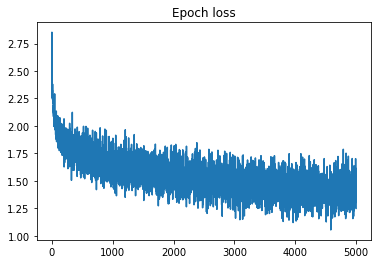

<Figure size 432x288 with 0 Axes>

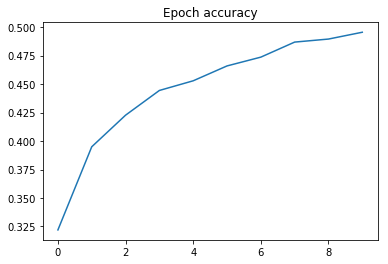

<Figure size 432x288 with 0 Axes>

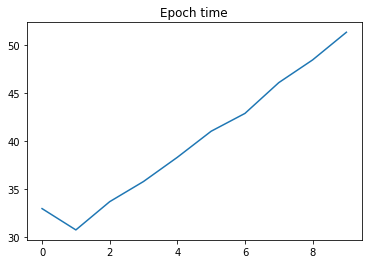

<Figure size 432x288 with 0 Axes>

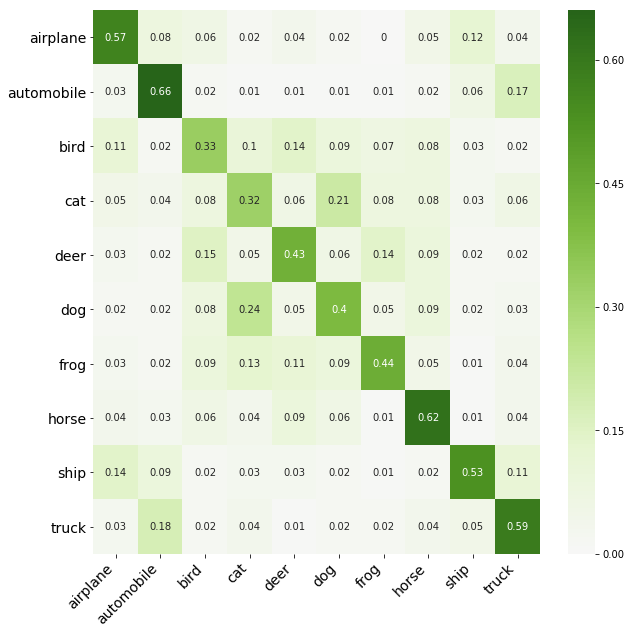

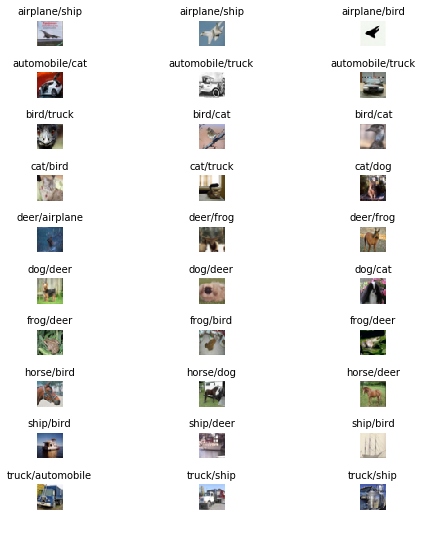

In [28]:
visualize(model, x_test, y_test)

In [43]:
def plot_tests(df, test):
    test_groupby = test[0]
    test_x = test[1]

    scores = ['acc', 'f1', 'time_per_epoch', 'time_overall']

    for score in scores:
        fig, ax = plt.subplots(figsize=(15, 10))
        for key, grp in df.groupby(test_groupby):
            ax = grp.plot(ax=ax, kind='line', x=test_x, y=score, label=key, style='.-',
                          title='{}'.format(score))
        plt.show()
        plt.clf()

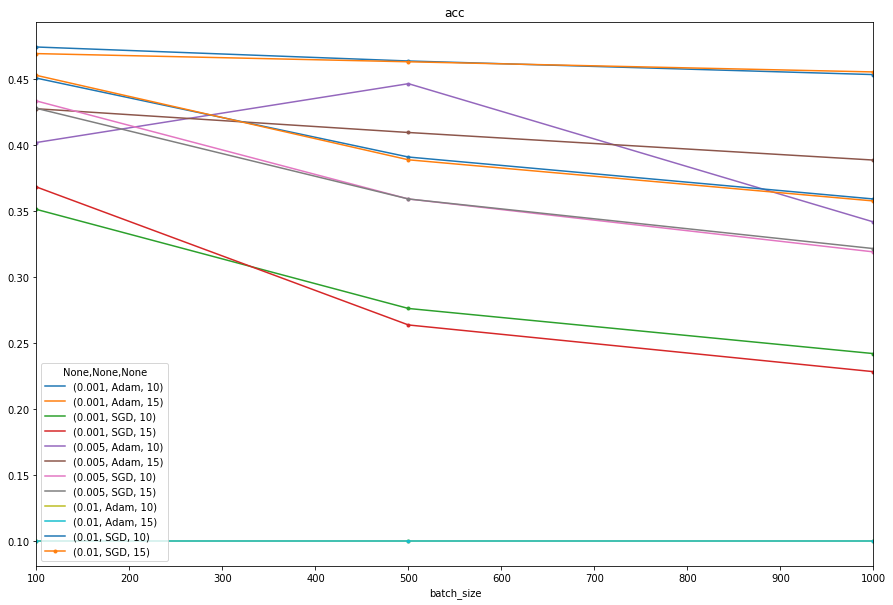

<Figure size 432x288 with 0 Axes>

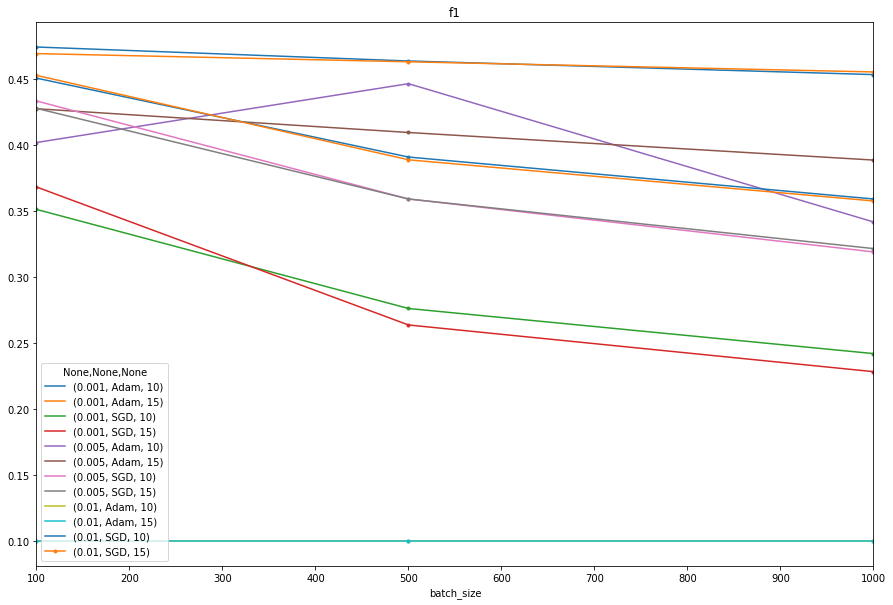

<Figure size 432x288 with 0 Axes>

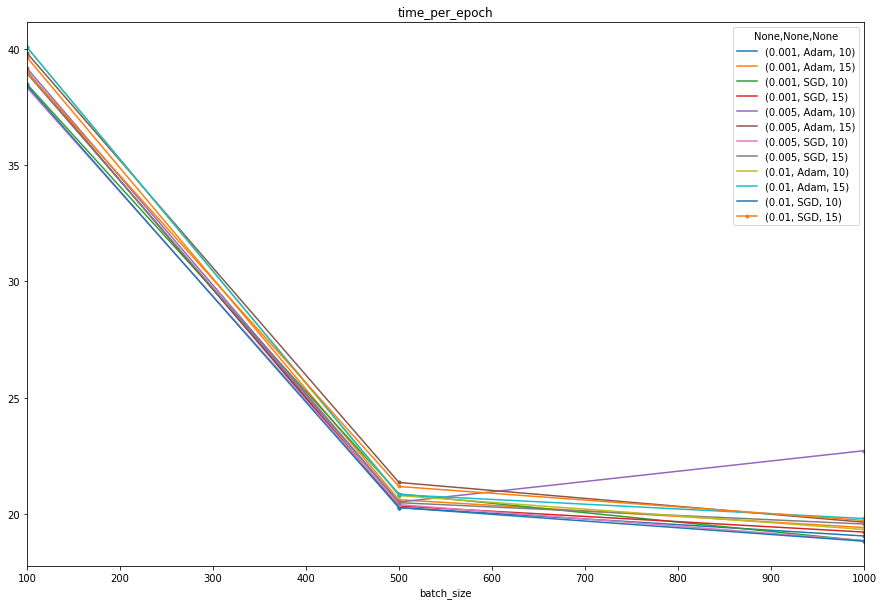

<Figure size 432x288 with 0 Axes>

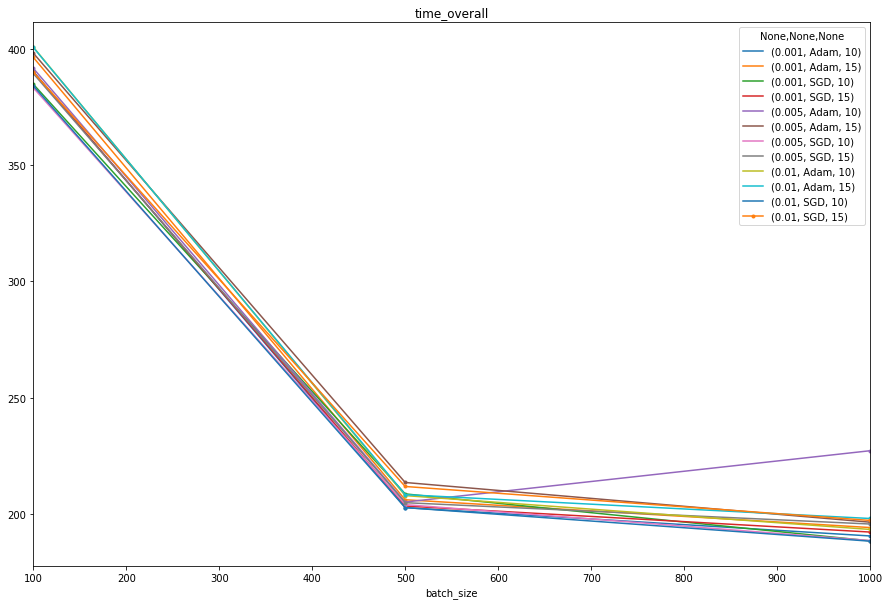

<Figure size 432x288 with 0 Axes>

In [45]:
tests_hiperparameters = [(['learning_coef', 'optimizer', 'epoch'], 'batch_size'), (['learning_coef', 'optimizer', 'batch_size'], 'epoch'), 
         (['learning_coef', 'epoch', 'batch_size'], 'optimizer'), (['optimizer', 'epoch', 'batch_size'], 'learning_coef')]
plot_tests(results_hiperparameters, tests_hiperparameters[0])

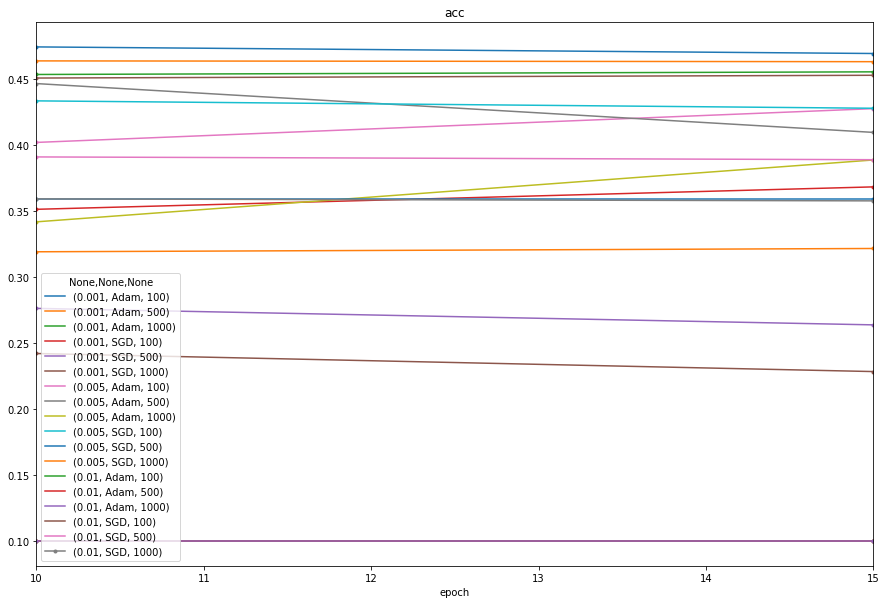

<Figure size 432x288 with 0 Axes>

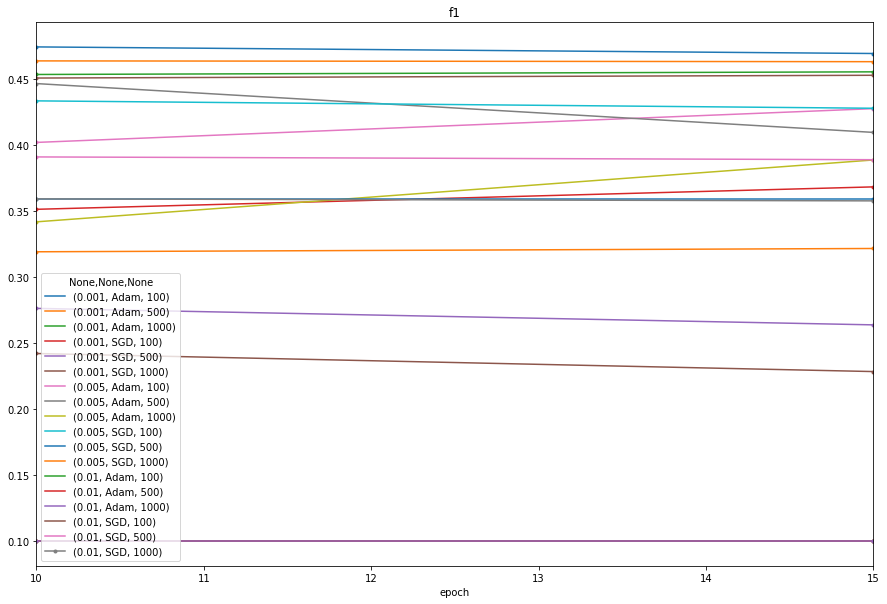

<Figure size 432x288 with 0 Axes>

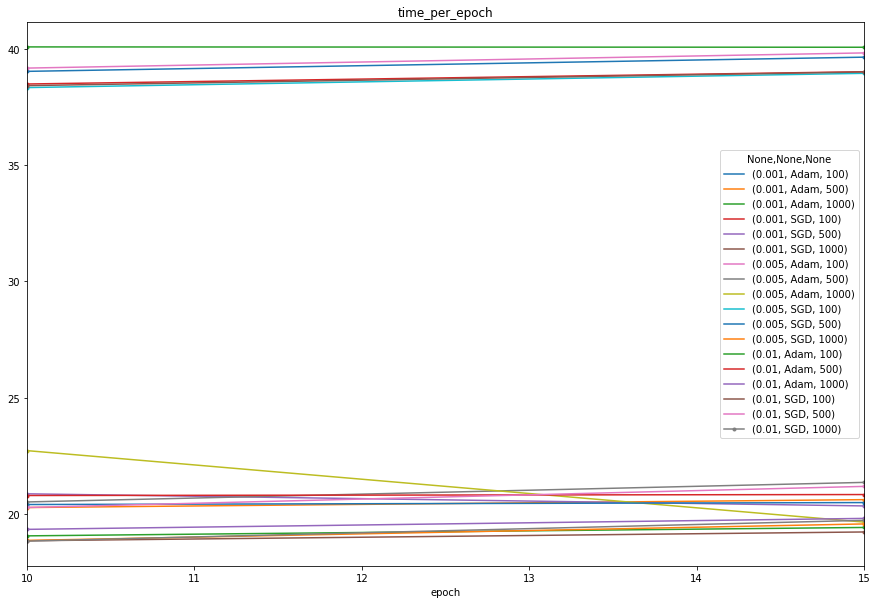

<Figure size 432x288 with 0 Axes>

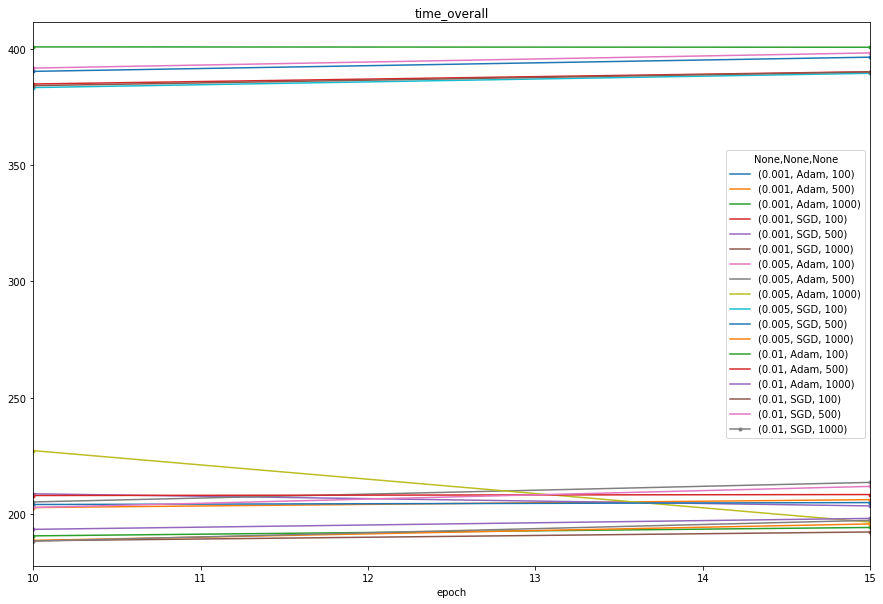

<Figure size 432x288 with 0 Axes>

In [46]:
plot_tests(results_hiperparameters, tests_hiperparameters[1])

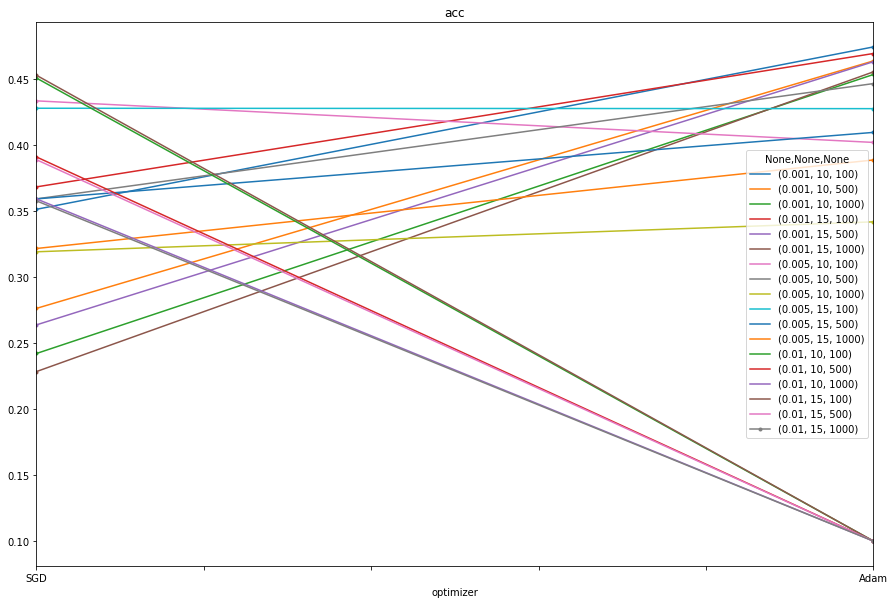

<Figure size 432x288 with 0 Axes>

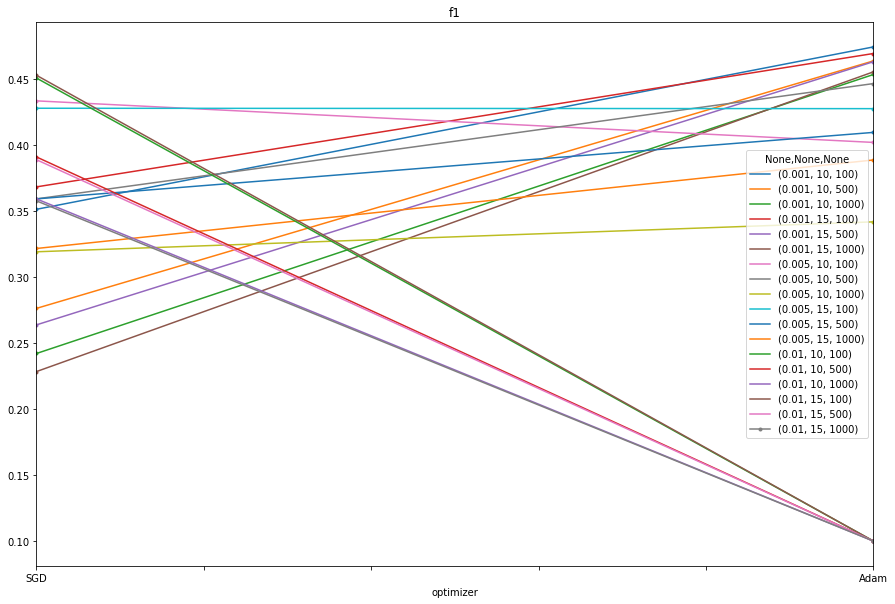

<Figure size 432x288 with 0 Axes>

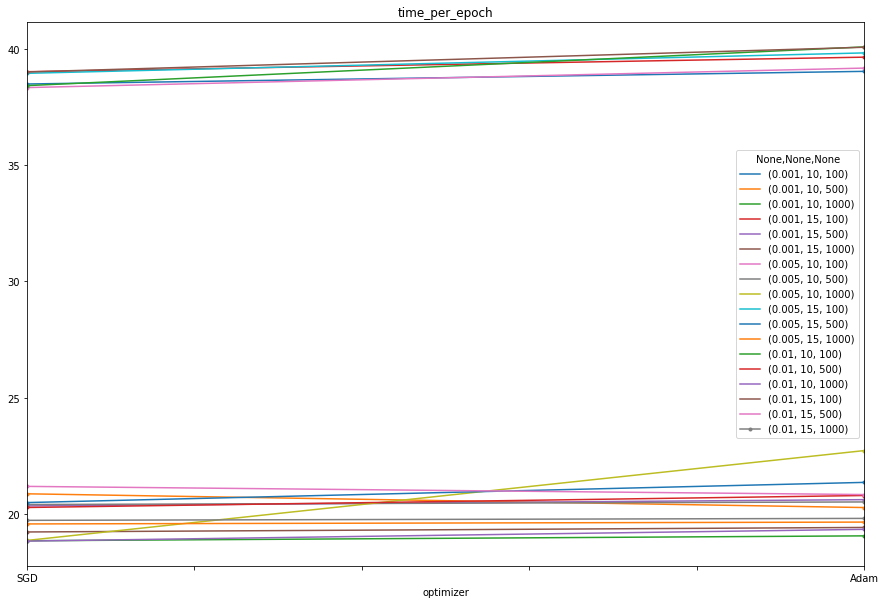

<Figure size 432x288 with 0 Axes>

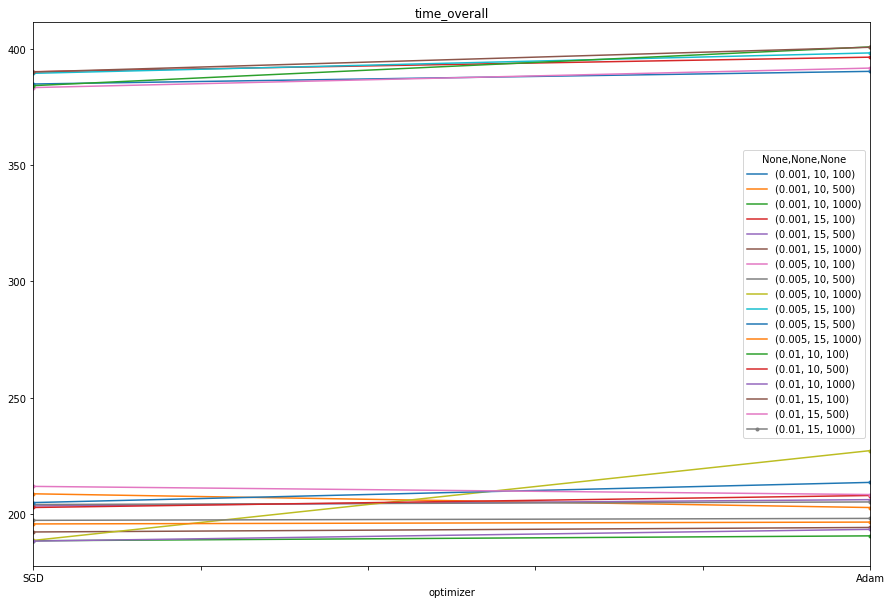

<Figure size 432x288 with 0 Axes>

In [47]:
plot_tests(results_hiperparameters, tests_hiperparameters[2])

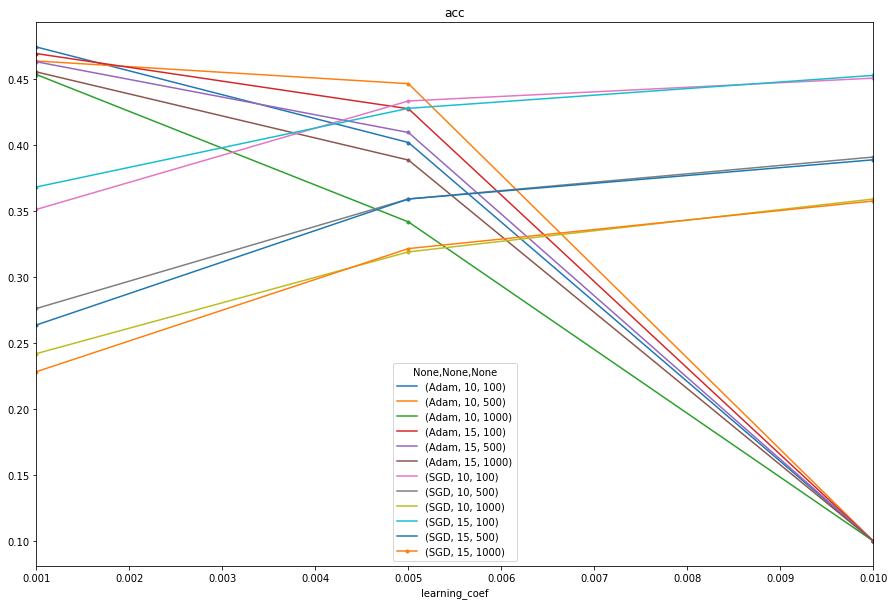

<Figure size 432x288 with 0 Axes>

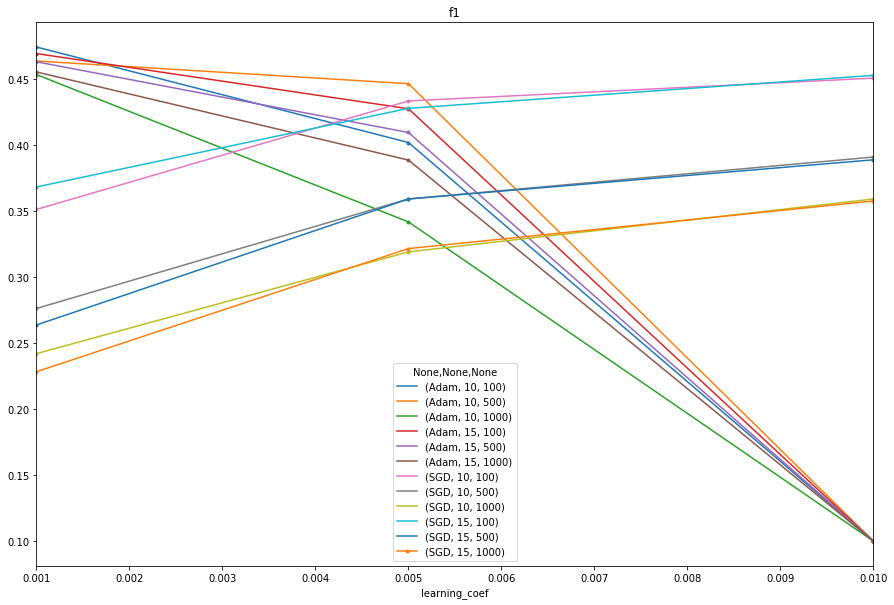

<Figure size 432x288 with 0 Axes>

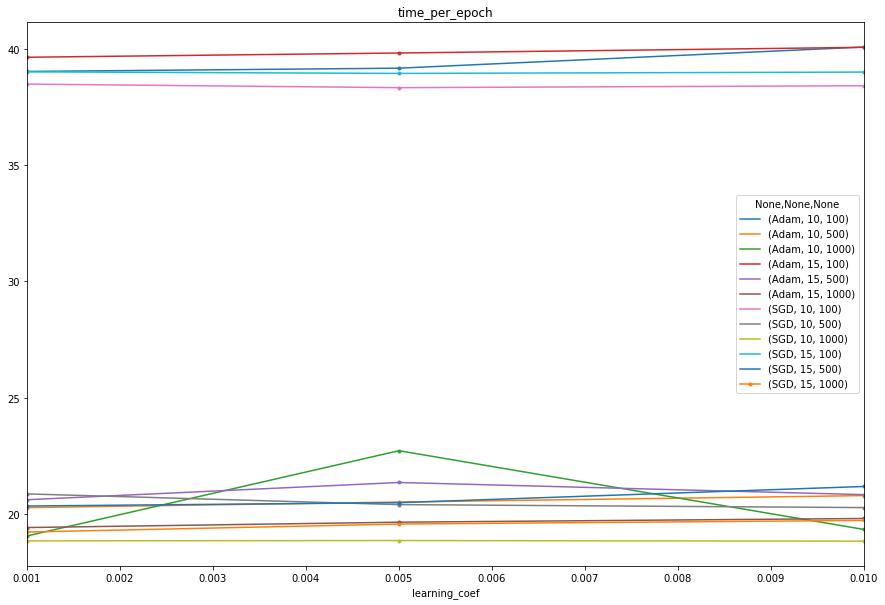

<Figure size 432x288 with 0 Axes>

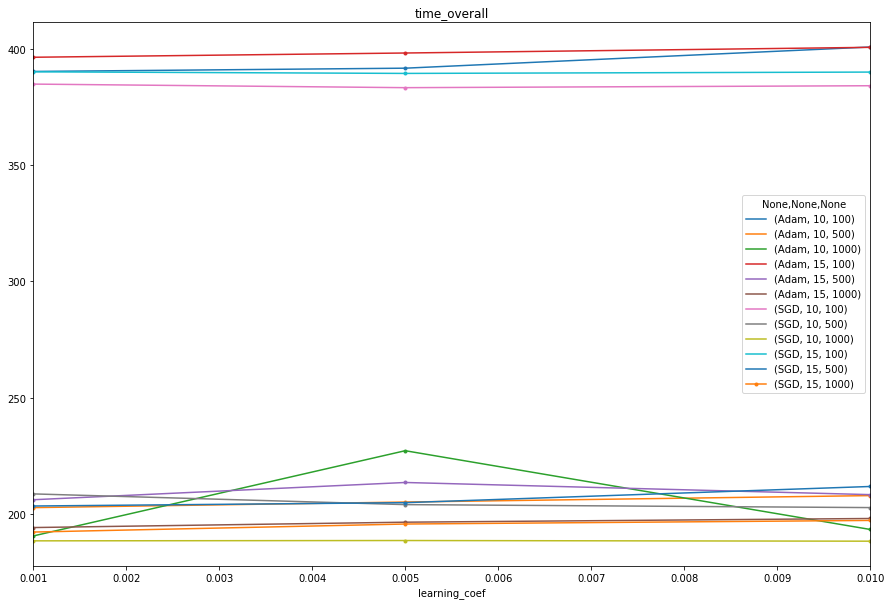

<Figure size 432x288 with 0 Axes>

In [48]:
plot_tests(results_hiperparameters, tests_hiperparameters[3])

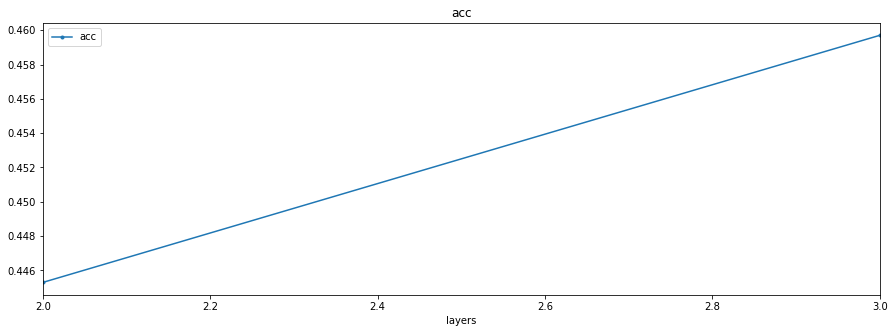

<Figure size 432x288 with 0 Axes>

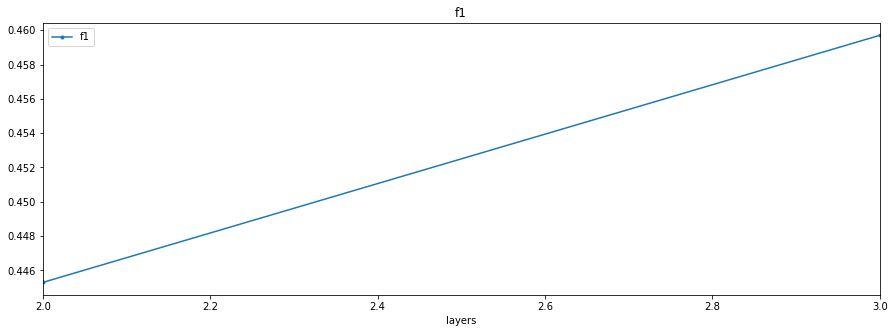

<Figure size 432x288 with 0 Axes>

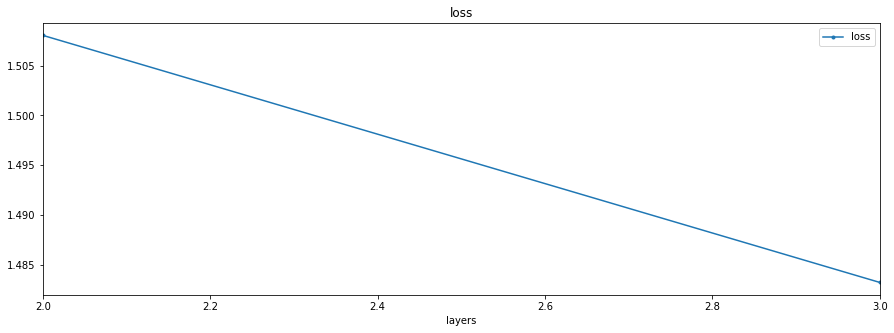

<Figure size 432x288 with 0 Axes>

In [50]:
# test_groupby = 'layers'
test_x = 'layers'

scores = ['acc', 'f1', 'loss']

df = results_layers

for score in scores:
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = results_layers.plot(ax=ax, kind='line', x=test_x, y=score, style='.-',
                  title='{}'.format(score))
    plt.show()
    plt.clf()

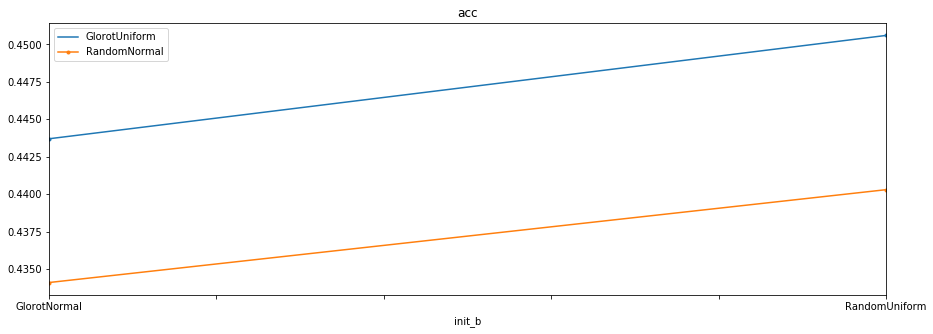

<Figure size 432x288 with 0 Axes>

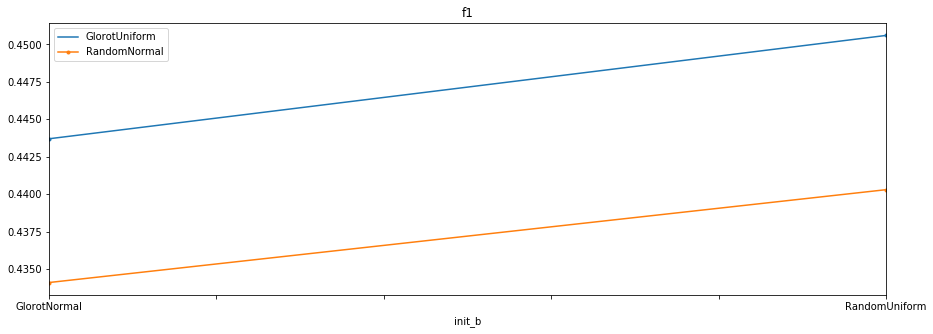

<Figure size 432x288 with 0 Axes>

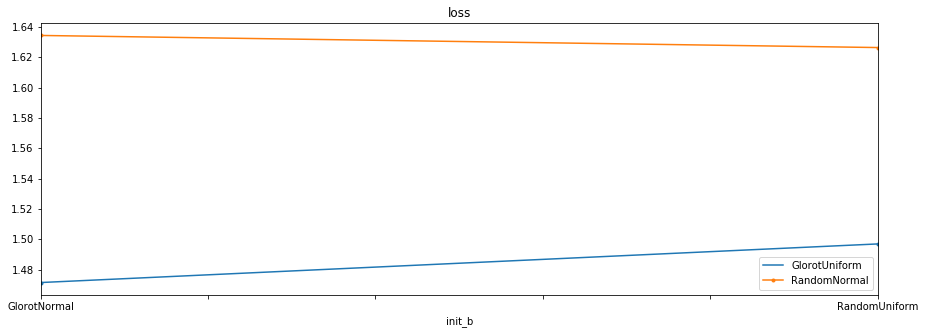

<Figure size 432x288 with 0 Axes>

In [54]:
test_groupby = ['init_w']
test_x = 'init_b'

scores = ['acc', 'f1', 'loss']

df = results_inits

for score in scores:
    fig, ax = plt.subplots(figsize=(15, 5))
    for key, grp in df.groupby(test_groupby):
        ax = grp.plot(ax=ax, kind='line', x=test_x, y=score, label=key, style='.-',
                      title='{}'.format(score))
    plt.show()
    plt.clf()

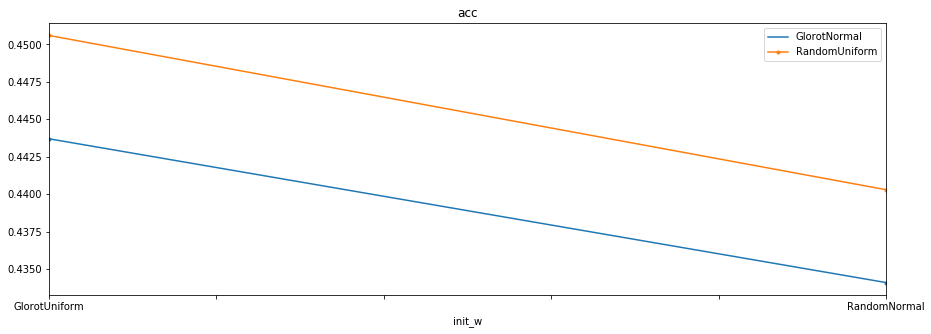

<Figure size 432x288 with 0 Axes>

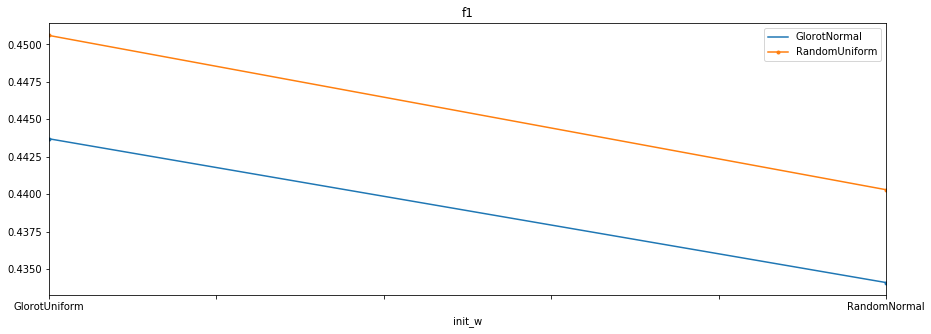

<Figure size 432x288 with 0 Axes>

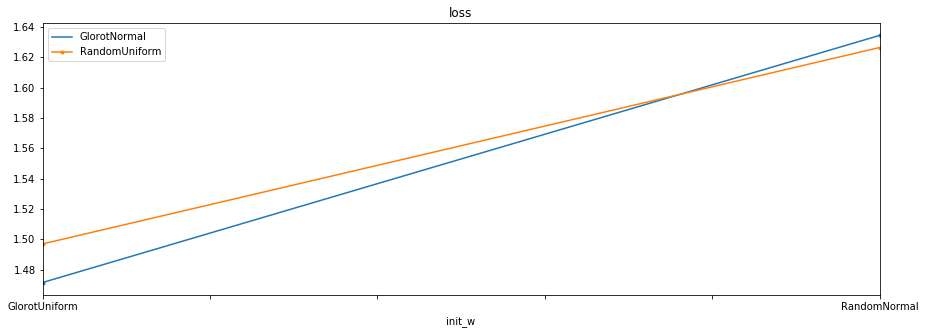

<Figure size 432x288 with 0 Axes>

In [55]:
test_groupby = ['init_b']
test_x = 'init_w'

scores = ['acc', 'f1', 'loss']

df = results_inits

for score in scores:
    fig, ax = plt.subplots(figsize=(15, 5))
    for key, grp in df.groupby(test_groupby):
        ax = grp.plot(ax=ax, kind='line', x=test_x, y=score, label=key, style='.-',
                      title='{}'.format(score))
    plt.show()
    plt.clf()

## Wnioski: 

    - minimalnie lepsze wyniki daje mniejsza paczka (batch_size), ale wydłuża czas uczenia;
    - zwiększenie liczby epok o 5 przynosi zaledwie nieznaczną poprawę;
    - lepszym optymalizatorem okazał się Adam dla learning_rate = 0.001;
    - SGD i Adam działają najlepiej dla przeciwnych wartości learning_rate (Adam dla 0.001, SGD dla 0.01)
    - najlepsze hiperparametry to: epoch = 10, learning_rate = 0.001, optimizer = Adam, batch_size = 100
    - 3 warstwy przyniosły lepsze wyniki Accuracy i F1 niż 2;
    - lepszym rozkładem inicjującym okazał się rozkład jednostajny, a nie normalny;